# Topik: Analisis Sentimen Opini Publik terhadap Kebijakan Pemindahan Dana Rp 200 Triliun ke Bank Himbara oleh Menteri Keuangan Purbaya melalui Komentar YouTube

## Notebook: Modeling Tanpa Class Netral

**Anggota Kelompok:**  
- 140810230011 - Lukas Austin  
- 140810230045 - Devin Suryadi  
- 140810230057 - Orlando Bloem Sutono  

Mata Kuliah: Data Mining  
Kelas: A  
Dosen: Bu Helen

---

**Metodologi:**
1. **Classical Machine Learning**: SVM, XGBoost, dan Naive Bayes dengan TF-IDF
2. **Perbedaan dengan modeling utama**: Class Netral dihilangkan (hanya Positif dan Negatif)
3. **Evaluasi**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix

## 1. Import Library
Library yang dibutuhkan untuk modeling dan evaluasi.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, precision_score, recall_score, precision_recall_fscore_support
)
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_colwidth', 200)

print("Library berhasil dimuat!")

Library berhasil dimuat!


## 2. Load Dataset dan Filter Class Netral

In [5]:
# Load dataset
df_full = pd.read_csv("dataset/dataset_labeled.csv")

print("DATASET ORIGINAL")
print(f"Total data: {len(df_full)} baris")
print("\nDistribusi sentimen original:")
print(df_full['sentiment'].value_counts())

# Filter: Hilangkan class Netral
df = df_full[df_full['sentiment'] != 'Netral'].copy()

print("DATASET REFINED (TANPA NETRAL)")
print("\nPersentase:")
print(df['sentiment'].value_counts(normalize=True) * 100)
print("Distribusi sentimen:")
print(df['sentiment'].value_counts())
print(f"\nTotal data: {len(df)} baris")
print(f"Data dihapus: {len(df_full) - len(df)} baris (class Netral)")


DATASET ORIGINAL
Total data: 1763 baris

Distribusi sentimen original:
sentiment
Negatif    720
Positif    684
Netral     359
Name: count, dtype: int64
DATASET REFINED (TANPA NETRAL)

Persentase:
sentiment
Negatif    51.282051
Positif    48.717949
Name: proportion, dtype: float64
Distribusi sentimen:
sentiment
Negatif    720
Positif    684
Name: count, dtype: int64

Total data: 1404 baris
Data dihapus: 359 baris (class Netral)


## 3. Eksplorasi Data
Analisis distribusi data dan karakteristik teks.

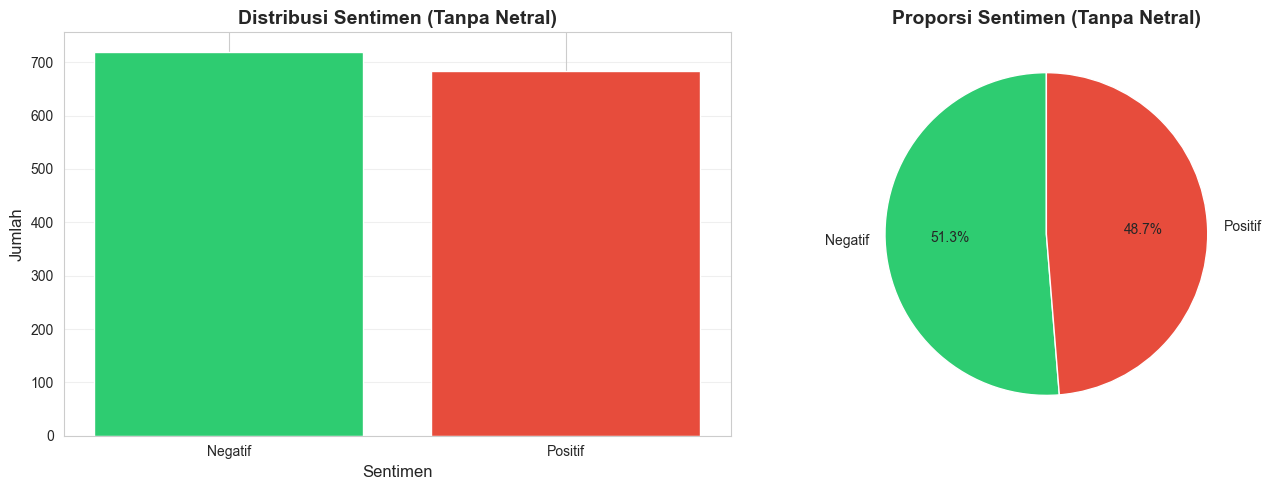

In [6]:
# Visualisasi distribusi sentimen
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
sentiment_counts = df['sentiment'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_xlabel('Sentimen', fontsize=12)
axes[0].set_ylabel('Jumlah', fontsize=12)
axes[0].set_title('Distribusi Sentimen (Tanpa Netral)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Proporsi Sentimen (Tanpa Netral)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Statistik Panjang Teks:
          word_count                                                     \
               count       mean        std  min  25%   50%   75%    max   
sentiment                                                                 
Negatif        720.0  19.070833  21.794699  1.0  8.0  13.0  22.0  210.0   
Positif        684.0  13.881579  11.234973  1.0  6.0  11.0  18.0  110.0   

          char_count                                                          
               count        mean         std  min   25%   50%    75%     max  
sentiment                                                                     
Negatif        720.0  119.770833  140.129610  4.0  46.0  82.5  136.0  1353.0  
Positif        684.0   87.135965   72.067627  7.0  39.0  64.5  112.0   688.0  


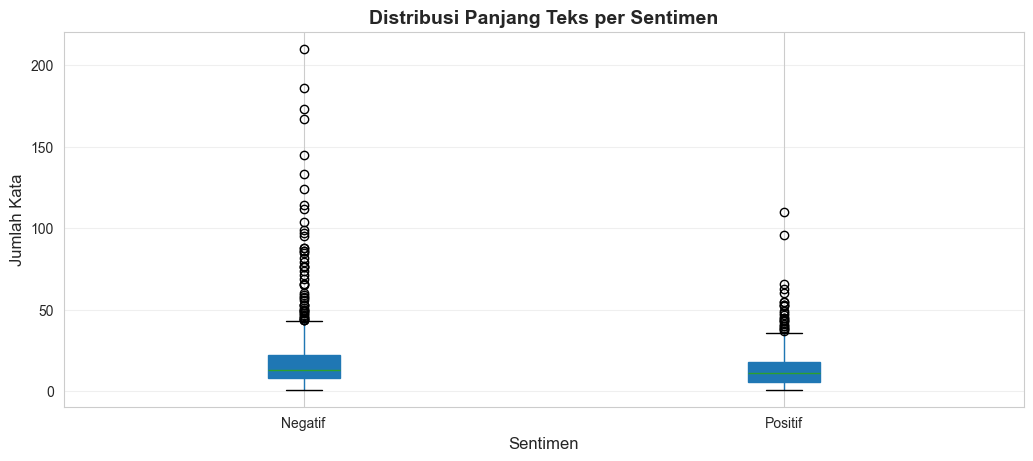

In [7]:
# Analisis panjang teks
df['word_count'] = df['comment'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['comment'].apply(lambda x: len(str(x)))

print("Statistik Panjang Teks:")
print(df.groupby('sentiment')[['word_count', 'char_count']].describe())

# Visualisasi distribusi panjang kata per sentimen
fig, ax = plt.subplots(figsize=(12, 5))
df.boxplot(column='word_count', by='sentiment', ax=ax, patch_artist=True)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Kata', fontsize=12)
plt.title('Distribusi Panjang Teks per Sentimen', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.grid(axis='y', alpha=0.3)
plt.show()

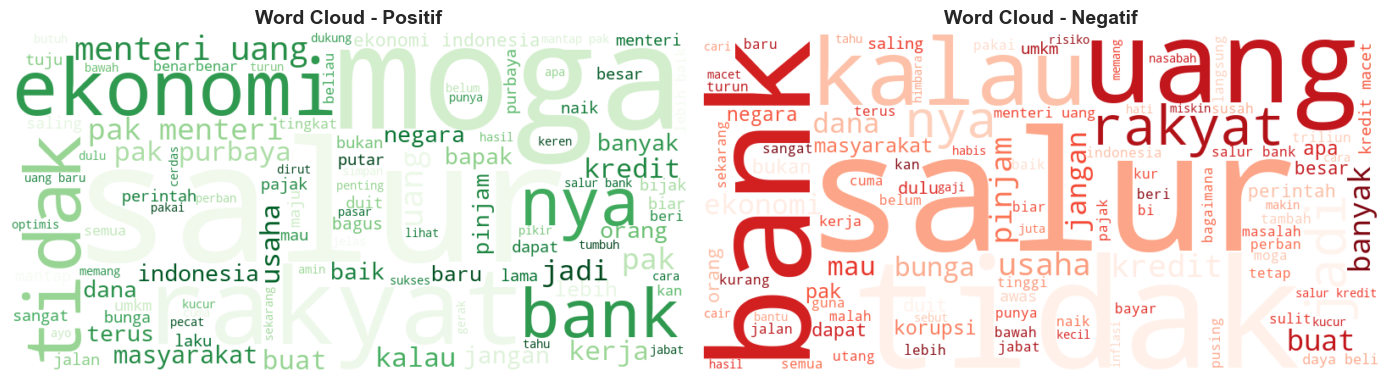

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sentiments = ['Positif', 'Negatif']
colors_wc = ['Greens', 'Reds']

for idx, (sentiment, cmap) in enumerate(zip(sentiments, colors_wc)):
    # Gabungkan semua komentar untuk sentimen tertentu
    text = ' '.join(df[df['sentiment'] == sentiment]['comment'].astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=cmap,
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud - {sentiment}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Persiapan Data untuk Training

Split data menjadi training dan testing set dengan data original (tanpa balancing).

In [9]:
# Distribusi data awal
print("DISTRIBUSI DATA")
print(f"Total data: {len(df)}")
print(f"\nDistribusi sentimen:")
print(df['sentiment'].value_counts())
print(f"\nPersentase:")
print(df['sentiment'].value_counts(normalize=True) * 100)

# Split data: 80% training, 20% testing
X = df['comment']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("SPLIT DATA (80% TRAIN, 20% TEST)")
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"\nDistribusi Training:")
print(y_train.value_counts())
print(f"\nDistribusi Testing:")
print(y_test.value_counts())

DISTRIBUSI DATA
Total data: 1404

Distribusi sentimen:
sentiment
Negatif    720
Positif    684
Name: count, dtype: int64

Persentase:
sentiment
Negatif    51.282051
Positif    48.717949
Name: proportion, dtype: float64
SPLIT DATA (80% TRAIN, 20% TEST)
Training set: 1123 samples
Testing set: 281 samples

Distribusi Training:
sentiment
Negatif    576
Positif    547
Name: count, dtype: int64

Distribusi Testing:
sentiment
Negatif    144
Positif    137
Name: count, dtype: int64


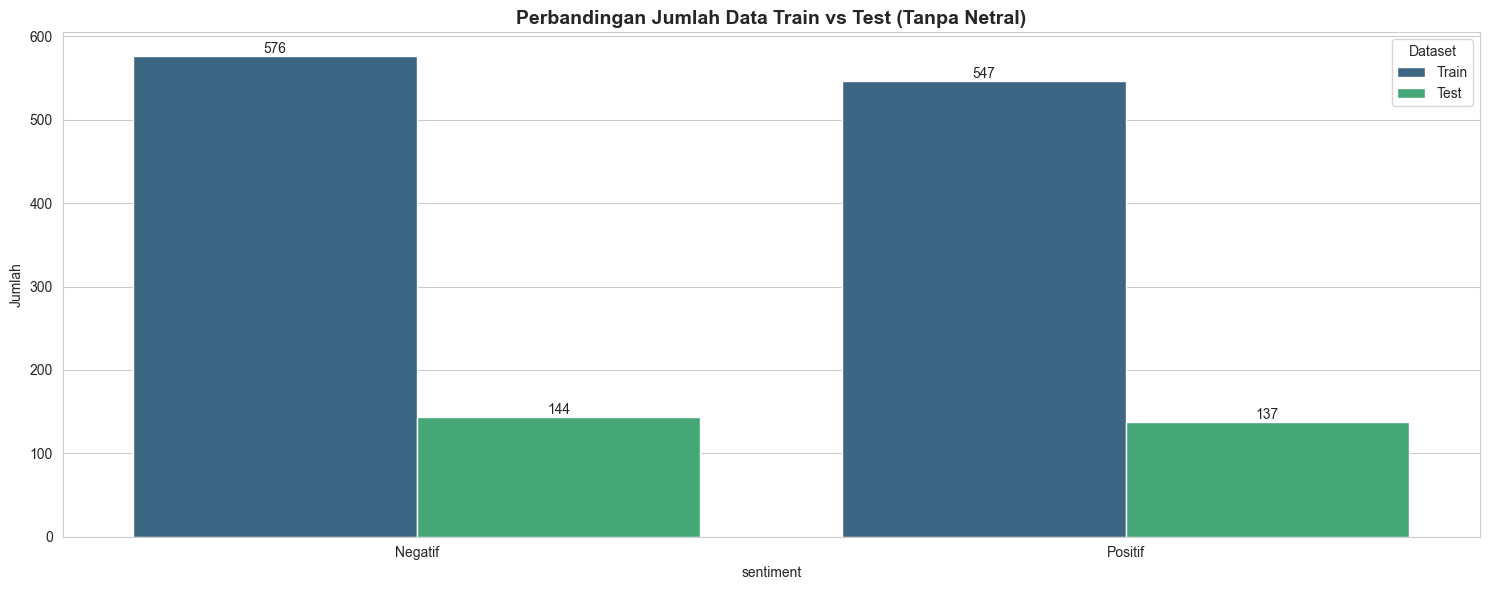

In [10]:
# Visualisasi distribusi data awal dan split
fig, ax = plt.subplots(figsize=(15, 6))

# Bar Chart
df_split = (
    pd.DataFrame({
        'Train': y_train.value_counts(),
        'Test': y_test.value_counts()
    })
    .reset_index()
    .rename(columns={'index': 'sentiment'})
    .melt(id_vars='sentiment', var_name='Dataset', value_name='Jumlah')
)

# Plotting Bar Chart
sns.barplot(data=df_split, x='sentiment', y='Jumlah', hue='Dataset', ax=ax, palette='viridis')
ax.set_title('Perbandingan Jumlah Data Train vs Test (Tanpa Netral)', fontsize=14, fontweight='bold')
for container in ax.containers:
    ax.bar_label(container)  # Label angka pada setiap bar

plt.tight_layout()
plt.show()

## 5. Feature Extraction dengan TF-IDF

In [11]:
# TF-IDF Transformation
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("=" * 80)
print("TF-IDF TRANSFORMATION")
print("=" * 80)
print(f"Training shape: {X_train_tfidf.shape}")
print(f"Testing shape: {X_test_tfidf.shape}")
print(f"Jumlah fitur: {len(tfidf_vectorizer.get_feature_names_out())}")
print("=" * 80)

TF-IDF TRANSFORMATION
Training shape: (1123, 2895)
Testing shape: (281, 2895)
Jumlah fitur: 2895


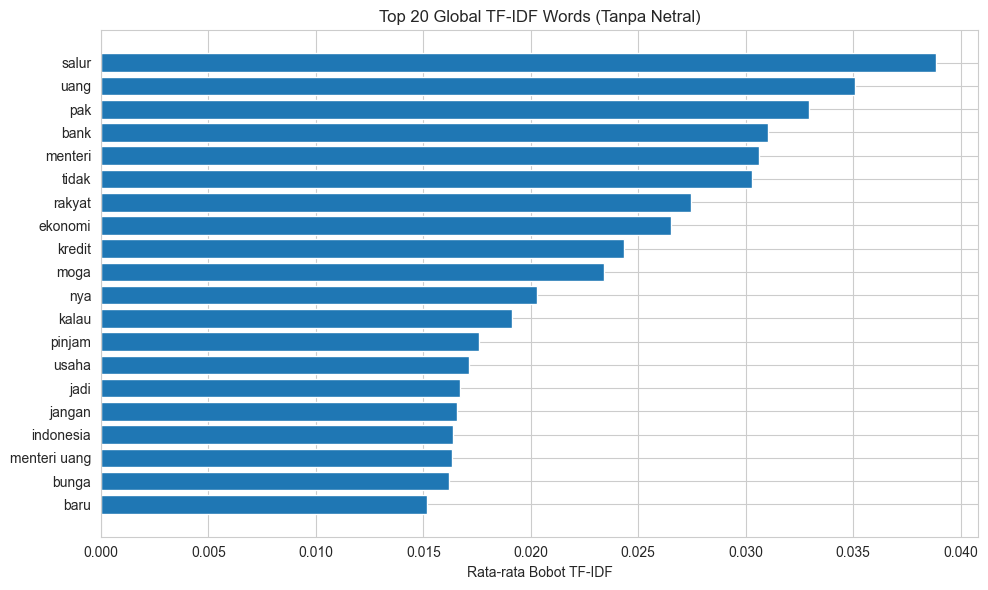

In [12]:
# Ambil feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Hitung rata-rata TF-IDF tiap kata (global)
mean_tfidf = X_train_tfidf.mean(axis=0).A1

# Ambil top-N kata
TOP_N = 20
top_idx = np.argsort(mean_tfidf)[-TOP_N:][::-1]

top_words = feature_names[top_idx]
top_scores = mean_tfidf[top_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_words[::-1], top_scores[::-1])
plt.xlabel("Rata-rata Bobot TF-IDF")
plt.title("Top 20 Global TF-IDF Words (Tanpa Netral)")
plt.tight_layout()
plt.show()

## 6. Model Training dengan K-Fold Cross Validation

In [13]:
# Setup K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Number of folds: 5")
print(f"Stratified: Yes")
print(f"Training samples: {X_train_tfidf.shape[0]}")

Number of folds: 5
Stratified: Yes
Training samples: 1123


### 6.1 Support Vector Machine (SVM) dengan GridSearchCV

In [14]:
# Hyperparameter tuning untuk SVM menggunakan GridSearchCV dengan K-Fold CV
print("Memulai hyperparameter tuning untuk SVM...")

# Define parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# Setup K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV untuk mencari parameter terbaik
svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=kfold,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Training dengan GridSearchCV pada data yang sudah di-SMOTE
svm_grid.fit(X_train_tfidf, y_train)

print("\n" + "=" * 80)
print("HASIL HYPERPARAMETER TUNING SVM")
print(f"Best Parameters: {svm_grid.best_params_}")
print(f"Best Cross-Validation F1-Score: {svm_grid.best_score_:.4f}")

# Model terbaik dari GridSearchCV
svm_model = svm_grid.best_estimator_

Memulai hyperparameter tuning untuk SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

HASIL HYPERPARAMETER TUNING SVM
Best Parameters: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation F1-Score: 0.8050


In [15]:
# Evaluasi SVM pada test set
y_pred_svm = svm_model.predict(X_test_tfidf)

print("\n" + "=" * 60)
print("SVM - EVALUASI PADA TEST SET")
print("=" * 60)
print(classification_report(y_test, y_pred_svm))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision (Weighted): {precision_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"Recall (Weighted): {recall_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")
print("=" * 60)


SVM - EVALUASI PADA TEST SET
              precision    recall  f1-score   support

     Negatif       0.79      0.88      0.83       144
     Positif       0.86      0.75      0.80       137

    accuracy                           0.82       281
   macro avg       0.82      0.82      0.82       281
weighted avg       0.82      0.82      0.82       281


Accuracy: 0.8185
Precision (Weighted): 0.8227
Recall (Weighted): 0.8185
F1-Score (Weighted): 0.8176


### 6.2 XGBoost dengan RandomizedSearchCV

In [16]:
# Hyperparameter tuning untuk XGBoost
print("Memulai hyperparameter tuning untuk XGBoost...")

# Encode label untuk XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = RandomizedSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid_xgb,
    n_iter=50,
    cv=5,
    scoring='f1_weighted',
    n_jobs=1,
    verbose=1,
    random_state=42
)

xgb_grid.fit(X_train_tfidf, y_train_encoded)

print("\n" + "=" * 80)
print("HASIL HYPERPARAMETER TUNING XGBOOST")
print("=" * 80)
print(f"Best Parameters: {xgb_grid.best_params_}")
print(f"Best Cross-Validation F1-Score: {xgb_grid.best_score_:.4f}")
print("=" * 80)

xgb_model = xgb_grid.best_estimator_

Memulai hyperparameter tuning untuk XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

HASIL HYPERPARAMETER TUNING XGBOOST
Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Cross-Validation F1-Score: 0.7846


In [17]:
# Evaluasi XGBoost pada test set
y_pred_xgb_encoded = xgb_model.predict(X_test_tfidf)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

print("\n" + "=" * 60)
print("XGBOOST - EVALUASI PADA TEST SET")
print("=" * 60)
print(classification_report(y_test, y_pred_xgb))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision (Weighted): {precision_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"Recall (Weighted): {recall_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print("=" * 60)


XGBOOST - EVALUASI PADA TEST SET
              precision    recall  f1-score   support

     Negatif       0.75      0.84      0.79       144
     Positif       0.81      0.70      0.75       137

    accuracy                           0.77       281
   macro avg       0.78      0.77      0.77       281
weighted avg       0.78      0.77      0.77       281


Accuracy: 0.7722
Precision (Weighted): 0.7761
Recall (Weighted): 0.7722
F1-Score (Weighted): 0.7709


### 6.3 Naive Bayes dengan GridSearchCV

In [18]:
# Hyperparameter tuning untuk Naive Bayes
print("Memulai hyperparameter tuning untuk Naive Bayes...")

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

nb_grid = GridSearchCV(
    MultinomialNB(),
    param_grid_nb,
    cv=kfold,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

nb_grid.fit(X_train_tfidf, y_train)

print("\n" + "=" * 80)
print("HASIL HYPERPARAMETER TUNING NAIVE BAYES")
print("=" * 80)
print(f"Best Parameters: {nb_grid.best_params_}")
print(f"Best Cross-Validation F1-Score: {nb_grid.best_score_:.4f}")
print("=" * 80)

nb_model = nb_grid.best_estimator_

Memulai hyperparameter tuning untuk Naive Bayes...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

HASIL HYPERPARAMETER TUNING NAIVE BAYES
Best Parameters: {'alpha': 2.0, 'fit_prior': True}
Best Cross-Validation F1-Score: 0.8064


In [19]:
# Evaluasi Naive Bayes pada test set
y_pred_nb = nb_model.predict(X_test_tfidf)

print("\n" + "=" * 60)
print("NAIVE BAYES - EVALUASI PADA TEST SET")
print("=" * 60)
print(classification_report(y_test, y_pred_nb))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision (Weighted): {precision_score(y_test, y_pred_nb, average='weighted'):.4f}")
print(f"Recall (Weighted): {recall_score(y_test, y_pred_nb, average='weighted'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")
print("=" * 60)


NAIVE BAYES - EVALUASI PADA TEST SET
              precision    recall  f1-score   support

     Negatif       0.75      0.90      0.82       144
     Positif       0.86      0.69      0.77       137

    accuracy                           0.80       281
   macro avg       0.81      0.79      0.79       281
weighted avg       0.81      0.80      0.79       281


Accuracy: 0.7972
Precision (Weighted): 0.8077
Recall (Weighted): 0.7972
F1-Score (Weighted): 0.7948


## 7. Confusion Matrix untuk Classical ML Models

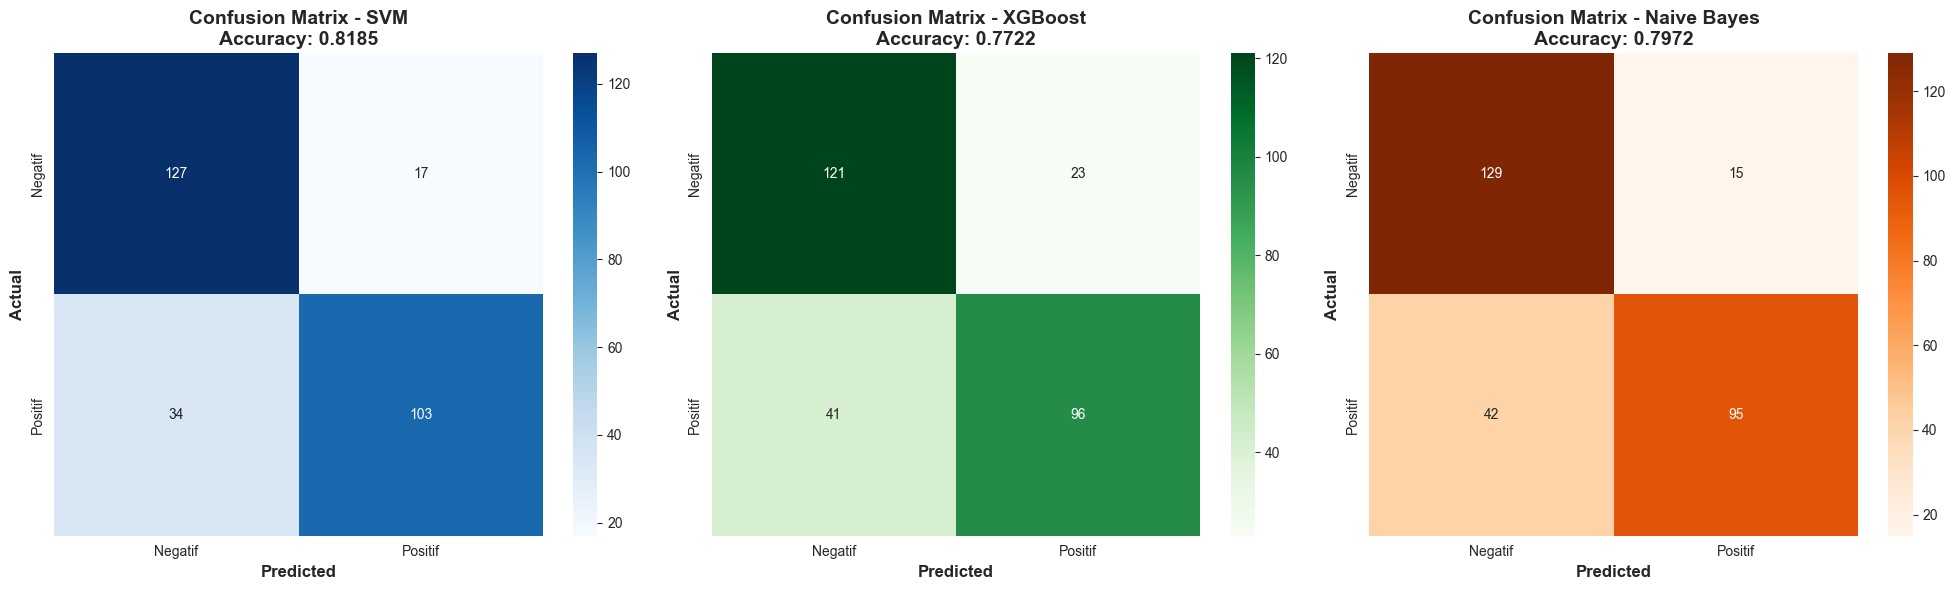

In [20]:
# Visualisasi Confusion Matrix untuk SVM, XGBoost, dan Naive Bayes
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Confusion Matrix SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(
    cm_svm,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=axes[0],
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0].set_title(
    f'Confusion Matrix - SVM\nAccuracy: {accuracy_score(y_test, y_pred_svm):.4f}',
    fontsize=14,
    fontweight='bold'
)

# Confusion Matrix XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[1],
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[1].set_title(
    f'Confusion Matrix - XGBoost\nAccuracy: {accuracy_score(y_test, y_pred_xgb):.4f}',
    fontsize=14,
    fontweight='bold'
)

# Confusion Matrix Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Oranges',
    ax=axes[2],
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
axes[2].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[2].set_title(
    f'Confusion Matrix - Naive Bayes\nAccuracy: {accuracy_score(y_test, y_pred_nb):.4f}',
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

## 8. Perbandingan Model SVM, XGBoost, dan Naive Bayes

In [21]:
# Kumpulkan hasil evaluasi semua model
models = ['SVM', 'XGBoost', 'Naive Bayes']
predictions = [y_pred_svm, y_pred_xgb, y_pred_nb]

results = []
for model_name, y_pred in zip(models, predictions):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_weighted
    })

results_df = pd.DataFrame(results)
results_df = results_df.round(4)

print("PERBANDINGAN PERFORMA MODEL")
print(results_df.to_string(index=False))

PERBANDINGAN PERFORMA MODEL
      Model  Accuracy  Precision  Recall  F1-Score
        SVM    0.8185     0.8227  0.8185    0.8176
    XGBoost    0.7722     0.7761  0.7722    0.7709
Naive Bayes    0.7972     0.8077  0.7972    0.7948


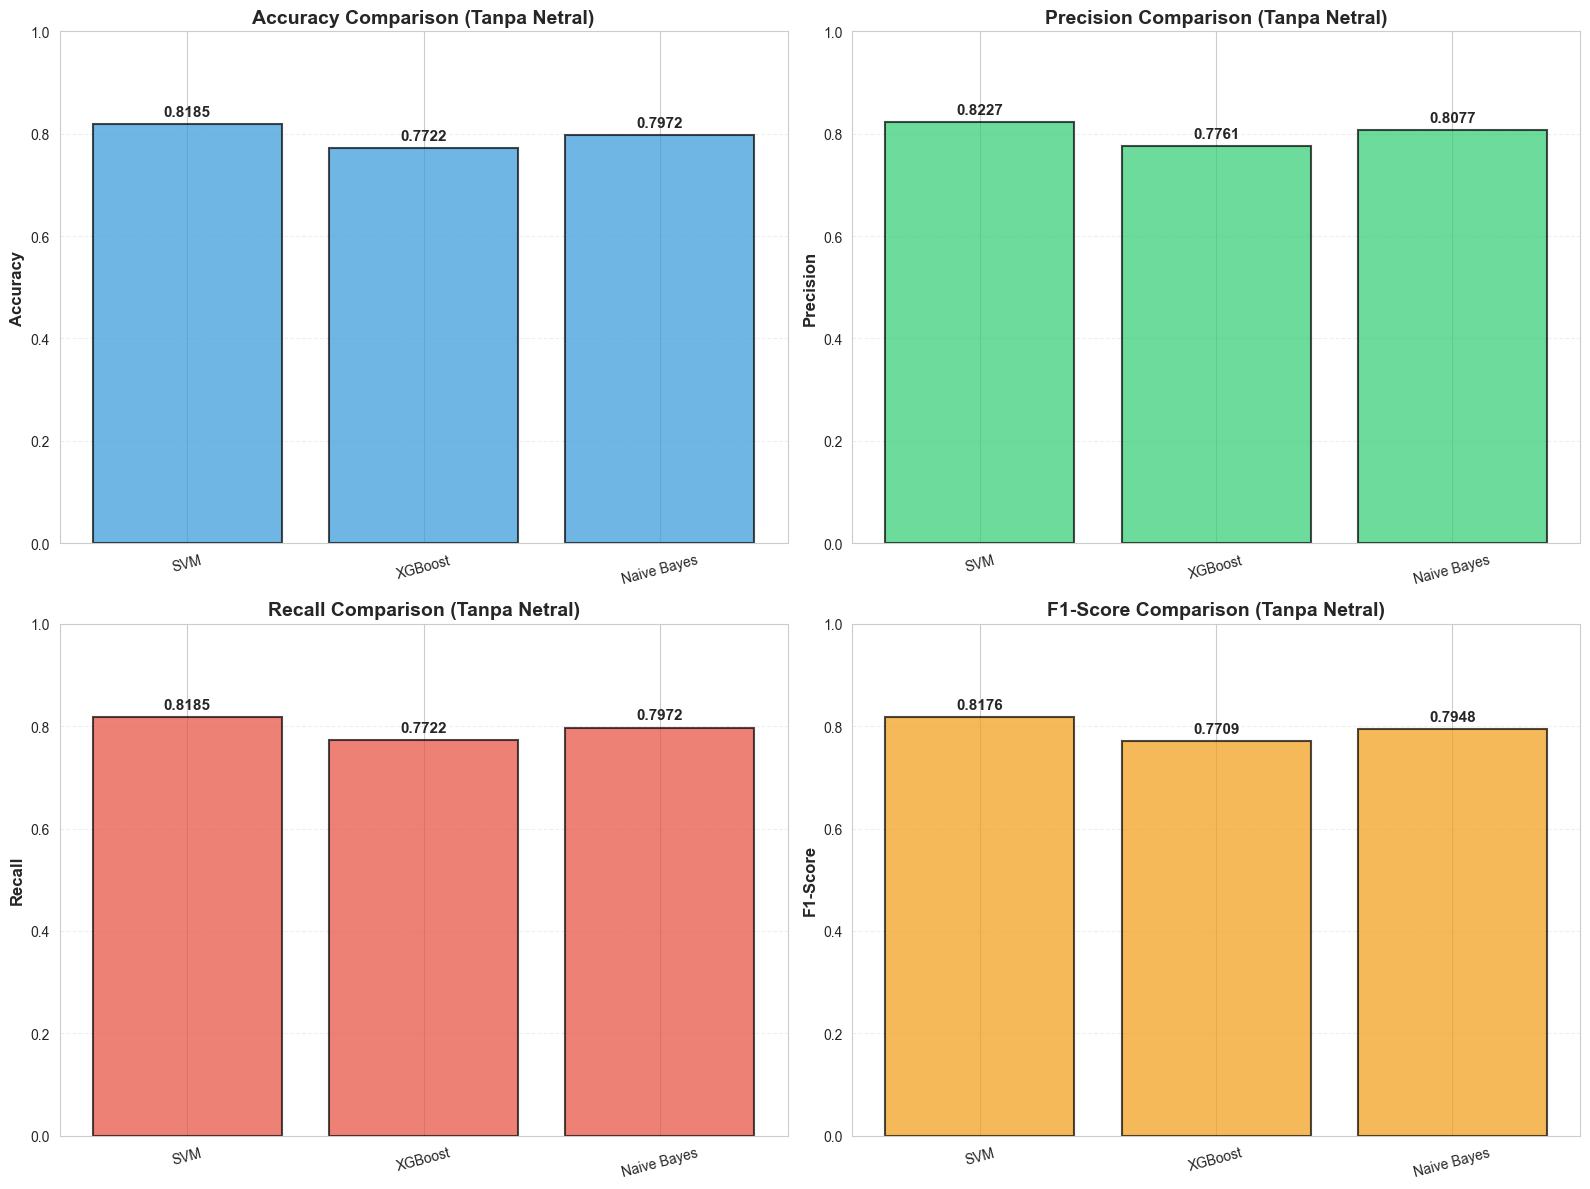

In [22]:
# Visualisasi perbandingan model - Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (ax, metric, color) in enumerate(zip(axes.flatten(), metrics, colors)):
    bars = ax.bar(results_df['Model'], results_df[metric], color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison (Tanpa Netral)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=15, labelsize=10)
    
    # Tambahkan nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

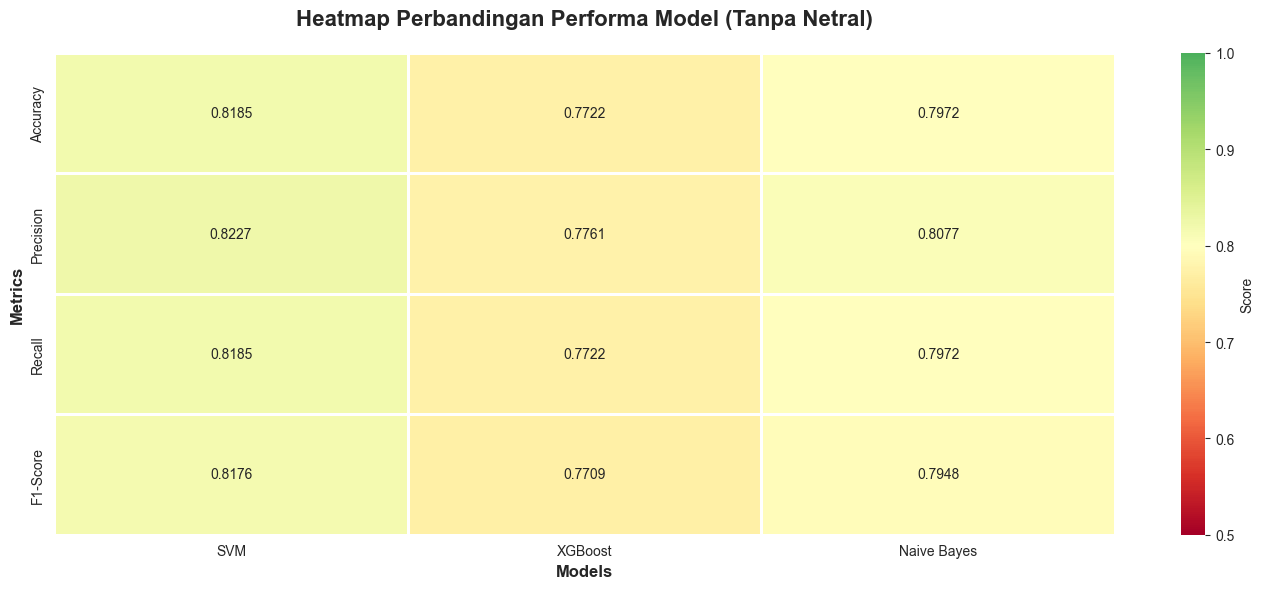

In [23]:
# Heatmap perbandingan semua metrik
plt.figure(figsize=(14, 6))
sns.heatmap(results_df.set_index('Model').T, annot=True, fmt='.4f', 
            cmap='RdYlGn', center=0.8, vmin=0.5, vmax=1.0, 
            cbar_kws={'label': 'Score'}, linewidths=2, linecolor='white')
plt.title('Heatmap Perbandingan Performa Model (Tanpa Netral)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Metrics', fontsize=12, fontweight='bold')
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Model Terbaik dan Kesimpulan

In [26]:
# Urutkan model berdasarkan F1-Score
results_ranked = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)
results_ranked.insert(0, 'Rank', range(1, len(results_ranked) + 1))

print("RANKING MODEL BERDASARKAN F1-SCORE (TANPA NETRAL)")
for idx, row in results_ranked.iterrows():
    print(f"\nRank {row['Rank']}: {row['Model']}")
    print(f"  Accuracy:  {row['Accuracy']:.4f}")
    print(f"  Precision: {row['Precision']:.4f}")
    print(f"  Recall:    {row['Recall']:.4f}")
    print(f"  F1-Score:  {row['F1-Score']:.4f}")

RANKING MODEL BERDASARKAN F1-SCORE (TANPA NETRAL)

Rank 1: SVM
  Accuracy:  0.8185
  Precision: 0.8227
  Recall:    0.8185
  F1-Score:  0.8176

Rank 2: Naive Bayes
  Accuracy:  0.7972
  Precision: 0.8077
  Recall:    0.7972
  F1-Score:  0.7948

Rank 3: XGBoost
  Accuracy:  0.7722
  Precision: 0.7761
  Recall:    0.7722
  F1-Score:  0.7709


In [27]:
# Simpan hasil perbandingan ke CSV
results_df.to_csv('model_comparison_results_refined.csv', index=False)
print("\nHasil perbandingan berhasil disimpan ke: model_comparison_results_refined.csv")


Hasil perbandingan berhasil disimpan ke: model_comparison_results_refined.csv


## 10. Simpan Model

In [28]:
import joblib
import pickle
import os

In [29]:
os.makedirs('models_refined', exist_ok=True)

# Simpan model classical ML
joblib.dump(svm_model, 'models_refined/svm_model.pkl')
joblib.dump(xgb_model, 'models_refined/xgboost_model.pkl')
joblib.dump(nb_model, 'models_refined/naive_bayes_model.pkl')
joblib.dump(tfidf_vectorizer, 'models_refined/tfidf_vectorizer.pkl')

# Simpan label encoder
with open('models_refined/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Simpan hasil GridSearchCV
with open('models_refined/svm_best_params.pkl', 'wb') as f:
    pickle.dump(svm_grid.best_params_, f)
with open('models_refined/xgb_best_params.pkl', 'wb') as f:
    pickle.dump(xgb_grid.best_params_, f)
with open('models_refined/nb_best_params.pkl', 'wb') as f:
    pickle.dump(nb_grid.best_params_, f)

print("SEMUA MODEL BERHASIL DISIMPAN!")
print("Lokasi:")
print("- SVM Model: models_refined/svm_model.pkl")
print("- XGBoost Model: models_refined/xgboost_model.pkl")
print("- Naive Bayes Model: models_refined/naive_bayes_model.pkl")
print("- TF-IDF Vectorizer: models_refined/tfidf_vectorizer.pkl")
print("- Label Encoder: models_refined/label_encoder.pkl")
print("- Best Parameters:")
print("  * SVM: models_refined/svm_best_params.pkl")
print("  * XGBoost: models_refined/xgb_best_params.pkl")
print("  * Naive Bayes: models_refined/nb_best_params.pkl")

SEMUA MODEL BERHASIL DISIMPAN!
Lokasi:
- SVM Model: models_refined/svm_model.pkl
- XGBoost Model: models_refined/xgboost_model.pkl
- Naive Bayes Model: models_refined/naive_bayes_model.pkl
- TF-IDF Vectorizer: models_refined/tfidf_vectorizer.pkl
- Label Encoder: models_refined/label_encoder.pkl
- Best Parameters:
  * SVM: models_refined/svm_best_params.pkl
  * XGBoost: models_refined/xgb_best_params.pkl
  * Naive Bayes: models_refined/nb_best_params.pkl
